In [9]:
torch.cuda.empty_cache()

In [3]:
!pip install transformers diffusers accelerate

  Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)
  Using cached diffusers-0.23.0-py3-none-any.whl (1.7 MB)
  Using cached accelerate-0.24.1-py3-none-any.whl (261 kB)
  Using cached huggingface_hub-0.19.1-py3-none-any.whl (311 kB)
  Using cached regex-2023.10.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (776 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached safetensors-0.4.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tokenizers-0.14.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (736 kB)
  Using cached Pillow-10.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)
ERROR: tokenizers 0.14.1 has requirement huggingface_hub<0.18,>=0.16.4, but you'll have huggingface-hub 0.19.1 which is incompatible.


In [2]:
!pip install xformers matplotlib torchvision

     |████████████████████████████████| 211.8 MB 157 kB/s  eta 0:00:01     |█████████████████               | 112.7 MB 88.8 MB/s eta 0:00:02
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached torch-2.1.0-cp38-cp38-manylinux1_x86_64.whl (670.2 MB)
  Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
     |████████████████████████████████| 56.5 MB 51.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 64.4 MB/s eta 0:00:01
     |████████████████████████████████| 121.6 MB 21.7 MB/s eta 0:00:01    |████████████████████▌           | 77.9 MB 20.1 MB/s eta 0:00:03
     |████████████████████████████████| 14.1 MB 35.1 MB/s eta 0:00:01
     |████████████████████████████████| 196.0 MB 140 kB/s  eta 0:00:01    |███▏                            | 19.2 MB 21.5 MB/s eta 0:00:09
     |████████████████████████████████| 133 kB 60.5 MB/s eta 0:00:01
     |████████████████████████████████| 23.7 MB 38.7 MB/s eta 0:00:01
     |██████

In [4]:
# @title Defining Pipeline
from diffusers import DiffusionPipeline
from diffusers.loaders import LoraLoaderMixin
import inspect
from typing import Callable, List, Optional, Union
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection

import PIL.Image
import torch
from packaging import version
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection, CLIPTextModel
from diffusers.image_processor import VaeImageProcessor
from diffusers import *
from diffusers.schedulers import KarrasDiffusionSchedulers



class CustomPipeline(DiffusionPipeline, LoraLoaderMixin):
    r"""
    Pipeline to generate image variations from an input image using Stable Diffusion.

    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods
    implemented for all pipelines (downloading, saving, running on a particular device, etc.).

    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) model to encode and decode images to and from latent representations.
        image_encoder ([`~transformers.CLIPVisionModelWithProjection`]):
            Frozen CLIP image-encoder ([clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)).
        text_encoder ([`~transformers.CLIPTextModel`]):
            Frozen text-encoder ([clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14)).
        tokenizer ([`~transformers.CLIPTokenizer`]):
            A `CLIPTokenizer` to tokenize text.
        unet ([`UNet2DConditionModel`]):
            A `UNet2DConditionModel` to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for more details
            about a model's potential harms.
        feature_extractor ([`~transformers.CLIPImageProcessor`]):
            A `CLIPImageProcessor` to extract features from generated images; used as inputs to the `safety_checker`.
    """
    # TODO: feature_extractor is required to encode images (if they are in PIL format),
    # we should give a descriptive message if the pipeline doesn't have one.
    model_cpu_offload_seq = "image_encoder->unet->vae"

    def __init__(
        self,
        vae: AutoencoderKL,
        image_encoder: CLIPVisionModelWithProjection,
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        feature_extractor: CLIPImageProcessor,
        text_encoder: CLIPTextModel = None,
        requires_safety_checker: bool = False
    ):
        super().__init__()


        self.register_modules(
            vae=vae,
            image_encoder=image_encoder,
            unet=unet,
            scheduler=scheduler,
            feature_extractor=feature_extractor,
            text_encoder=text_encoder
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    def encode_image(self, image, device, num_images_per_prompt):
        do_classifier_free_guidance = True
        dtype = next(self.image_encoder.parameters()).dtype

        if not isinstance(image, torch.Tensor):
            image = self.feature_extractor(images=image, return_tensors="pt").pixel_values

        print("shape of the input image(tensor) is: "+ str(image.shape))
        image = image.to(device=device, dtype=dtype)
        image_embeddings = self.image_encoder(image).image_embeds
        image_embeddings = image_embeddings.unsqueeze(1)

        # duplicate image embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = image_embeddings.shape
        image_embeddings = image_embeddings.repeat(1, num_images_per_prompt, 1)
        image_embeddings = image_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        if do_classifier_free_guidance:
            negative_prompt_embeds = torch.zeros_like(image_embeddings)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            image_embeddings = torch.cat([negative_prompt_embeds, image_embeddings])

        return image_embeddings


    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.decode_latents
    def decode_latents(self, latents):

        latents = 1 / self.vae.config.scaling_factor * latents
        image = self.vae.decode(latents, return_dict=False)[0]
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloat16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_extra_step_kwargs
    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(self, height, width, callback_steps):

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.prepare_latents
    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, device, generator, latents=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        else:
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.enable_freeu
    def enable_freeu(self, s1: float, s2: float, b1: float, b2: float):
        r"""Enables the FreeU mechanism as in https://arxiv.org/abs/2309.11497.

        The suffixes after the scaling factors represent the stages where they are being applied.

        Please refer to the [official repository](https://github.com/ChenyangSi/FreeU) for combinations of the values
        that are known to work well for different pipelines such as Stable Diffusion v1, v2, and Stable Diffusion XL.

        Args:
            s1 (`float`):
                Scaling factor for stage 1 to attenuate the contributions of the skip features. This is done to
                mitigate "oversmoothing effect" in the enhanced denoising process.
            s2 (`float`):
                Scaling factor for stage 2 to attenuate the contributions of the skip features. This is done to
                mitigate "oversmoothing effect" in the enhanced denoising process.
            b1 (`float`): Scaling factor for stage 1 to amplify the contributions of backbone features.
            b2 (`float`): Scaling factor for stage 2 to amplify the contributions of backbone features.
        """
        if not hasattr(self, "unet"):
            raise ValueError("The pipeline must have `unet` for using FreeU.")
        self.unet.enable_freeu(s1=s1, s2=s2, b1=b1, b2=b2)

    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline.disable_freeu
    def disable_freeu(self):
        """Disables the FreeU mechanism if enabled."""
        self.unet.disable_freeu()

    @torch.no_grad()
    def __call__(
        self,
        # image: Union[PIL.Image.Image, List[PIL.Image.Image], torch.FloatTensor],
        input_latents: torch.FloatTensor,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 20,
        guidance_scale: float = 7.5,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
    ):
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(height, width, callback_steps)

        # 2. Define call parameters
        batch_size=1
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input image
        # image_embeddings = self.encode_image(image, device, num_images_per_prompt, do_classifier_free_guidance)
        image_embeddings = input_latents

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            image_embeddings.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                print("the shape of the input image_embeddings is: " + str(image_embeddings.shape))
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=image_embeddings).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        self.maybe_free_model_hooks()

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False)[0]
            # image, has_nsfw_concept = self.run_safety_checker(image, device, image_embeddings.dtype)
        else:
            image = latents
            has_nsfw_concept = None
        has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from diffusers import LCMScheduler, DiffusionPipeline, AutoPipelineForText2Image, StableDiffusionImageVariationPipeline
import torch
from PIL import Image


adapter_id = "latent-consistency/lcm-lora-sdv1-5"

pipe = CustomPipeline.from_pretrained(
  "lambdalabs/sd-image-variations-diffusers",
  revision="v2.0",
  )
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

pipe.enable_xformers_memory_efficient_attention()
# pipe.disable_xformers_memory_efficient_attention()
pipe.to("cuda")

pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()


# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda") tried for speed ups, didn't speed up too much
# vae = ConsistencyDecoderVAE.from_pretrained("openai/consistency-decoder", torch_dtype=torch.float16)

# pipe.vae = vae


(…)-diffusers/resolve/v2.0/model_index.json: 100%|██████████| 545/545 [00:00<00:00, 63.5kB/s]
safety_checker/model.safetensors not found
(…)-diffusers/resolve/v2.0/model_index.json: 100%|██████████| 545/545 [00:00<00:00, 63.5kB/s]
safety_checker/model.safetensors not found
(…)568dcccb9b29fc/image_encoder/config.json: 100%|██████████| 703/703 [00:00<00:00, 23.5kB/s]



(…)cb9b29fc/scheduler/scheduler_config.json: 100%|██████████| 284/284 [00:00<00:00, 10.2kB/s]
(…)68dcccb9b29fc/safety_checker/config.json: 100%|██████████| 5.01k/5.01k [00:00<00:00, 108kB/s]
(…)cc9e3f85d568dcccb9b29fc/unet/config.json: 100%|██████████| 871/871 [00:00<00:00, 55.0kB/s]






(…)dcc9e3f85d568dcccb9b29fc/vae/config.json: 100%|██████████| 595/595 [00:00<00:00, 362kB/s]























































































































































































































































In [11]:
from PIL import Image
from transformers import CLIPImageProcessor, CLIPVisionModelWithProjection
import requests
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from torchvision import transforms
import torch



device = torch.device("cuda")
generator = torch.Generator("cuda").manual_seed(25436)


def get_latents(image): # takes in image as input and returns latents with CLIP

  tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BICUBIC,
        antialias=False,
        ),
    transforms.Normalize(
      [0.48145466, 0.4578275, 0.40821073],
      [0.26862954, 0.26130258, 0.27577711]),
])


  output= CustomPipeline.encode_image(pipe, tform(image).unsqueeze(0), device, 1) # wanderer above fog
  return output


def slerp(a, b, n, eps=1e-8):
    a_norm = a / torch.norm(a)
    b_norm = b / torch.norm(b)
    omega = torch.acos((a_norm * b_norm).sum()) + eps
    so = torch.sin(omega)
    return (torch.sin((1.0 - n) * omega) / so) * a + (torch.sin(n * omega) / so) * b

def process_latents(latents, operation): # apply mean, average, etc
    if operation == "mean":
      return torch.stack(latents).mean(dim=0)
    if operation == "sum":
      return torch.sum(torch.stack(latents), dim=0)
    if operation == "slerp":
      start_embedding = latents[0]
      end_embedding = latents[1]
      interpolated = []
      for t in torch.linspace(0, 1, 10):
        latent = slerp(start_embedding, end_embedding, t)
        interpolated.append(latent)
      return torch.stack(interpolated)




def generate_image(latents): # takes in latents as input and generates an image with SD
  # ATTENTION: FOR SOME REASON, SETTING GUIDANCE SCALE TO 1 ABSOLUTELY FUCKS UP THE WHOLE PIPELINE, SAVE YOUR BRAIN CELLS
  images = pipe(latents, num_inference_steps=4, guidance_scale=1.2, num_images_per_prompt=1, generator=generator)
  return images


# cars = [
#     "https://hips.hearstapps.com/hmg-prod/images/2024-lamborghini-revuelto-127-641a1d518802b.jpg?crop=0.813xw:0.721xh;0.0994xw,0.128xh&resize=1200:*",
#       "https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/F-35A_flight_%28cropped%29.jpg/600px-F-35A_flight_%28cropped%29.jpg"
#       ]

# paintings = [
#     "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg/440px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project_%28454045%29.jpg",

#     "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Vincent_van_Gogh_-_Sunflowers_-_VGM_F458.jpg/520px-Vincent_van_Gogh_-_Sunflowers_-_VGM_F458.jpg"
# ]

# latents = []
# for url in paintings:
#   image = Image.open(requests.get(url, stream=True).raw)
#   latent = get_latents(image)
#   latents.append(latent)

# op = "slerp"
# result = process_latents(latents, operation=op)
# print(result.shape) # should be torch.Size([10, 2, 1, 768]) for slerp

# if op=="slerp":
#   for i in range(result.shape[0]):
#     # display(generate_image(result[i]).images[0])
#     generate_image(result[i]).images[0].save(f"image{i}.png")
# else:
#   display(generate_image(result).images[0])



In [12]:
pipe

CustomPipeline {
  "_class_name": "CustomPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "lambdalabs/sd-image-variations-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": true,
  "scheduler": [
    "diffusers",
    "LCMScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [21]:
import glob
import os
oceans = []
barren = []
ocean_dir = '/workspace/oceans'
barren_dir = '/workspace/barren'
ocean_paths_jpg = glob.glob(os.path.join(ocean_dir, '*.jpg'))
ocean_paths_png = glob.glob(os.path.join(ocean_dir, '*.png'))
barren_paths_jpg = glob.glob(os.path.join(barren_dir, '*.jpg'))
barren_paths_png = glob.glob(os.path.join(barren_dir, '*.png'))

# Combine the lists of paths
ocean_paths = ocean_paths_jpg + ocean_paths_png
barren_paths = barren_paths_jpg + barren_paths_png

ocean_latents = []
for image_path in ocean_paths:
    image = Image.open(image_path).convert('RGB')
    ocean_latents.append(get_latents(image))

barren_latents = []
for image_path in barren_paths:
    image = Image.open(image_path).convert('RGB')
    barren_latents.append(get_latents(image))


mean_ocean_embeddings = torch.mean(torch.stack(ocean_latents), dim=0)
mean_ocean_embeddings.shape


mean_barren_embeddings = torch.mean(torch.stack(barren_latents), dim=0)
mean_barren_embeddings.shape

shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
shape of t

torch.Size([2, 1, 768])

In [19]:
ocean_latents

[]

shape of the input image(tensor) is: torch.Size([1, 3, 224, 224])
negative × 0.00


 25%|██▌       | 1/4 [00:00<00:00,  7.77it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.09it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]


negative × 0.11


 25%|██▌       | 1/4 [00:00<00:00,  8.53it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.40it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.39it/s]


negative × 0.22


 25%|██▌       | 1/4 [00:00<00:00,  8.45it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.35it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


negative × 0.33


 25%|██▌       | 1/4 [00:00<00:00,  8.46it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.39it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


negative × 0.44


 25%|██▌       | 1/4 [00:00<00:00,  8.46it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.39it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


negative × 0.56


 25%|██▌       | 1/4 [00:00<00:00,  8.48it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.39it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.38it/s]


negative × 0.67


 25%|██▌       | 1/4 [00:00<00:00,  8.45it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.36it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


negative × 0.78


 25%|██▌       | 1/4 [00:00<00:00,  8.42it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.34it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


negative × 0.89


 25%|██▌       | 1/4 [00:00<00:00,  8.43it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.38it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


negative × 1.00


 25%|██▌       | 1/4 [00:00<00:00,  8.46it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


 75%|███████▌  | 3/4 [00:00<00:00,  8.37it/s]

the shape of the input image_embeddings is: torch.Size([2, 1, 768])
the shape of the input image_embeddings is: torch.Size([2, 1, 768])


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


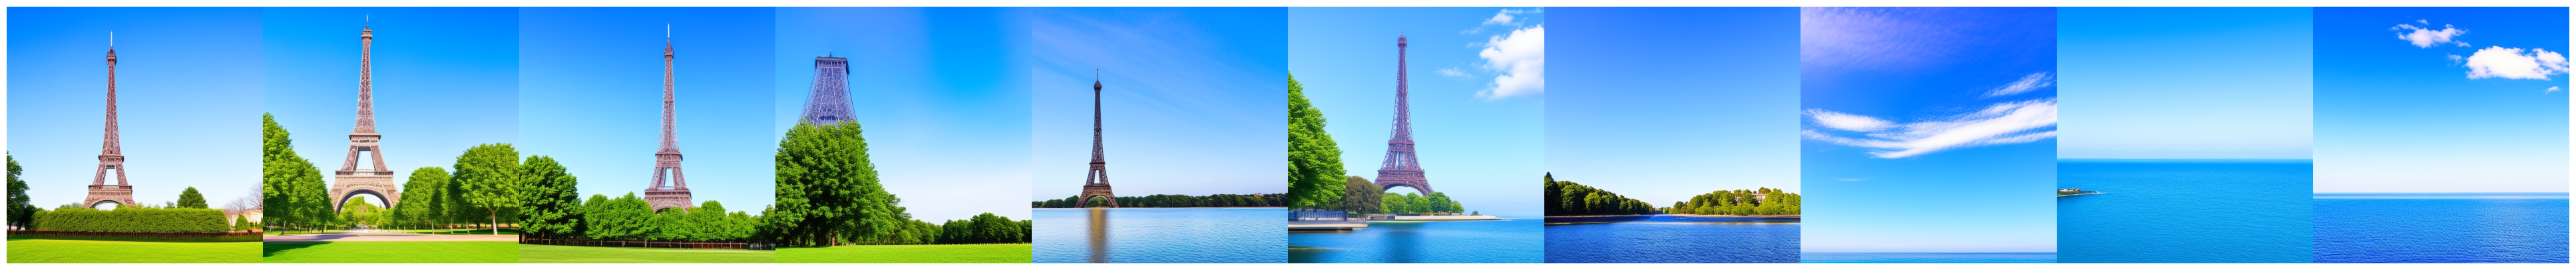

In [31]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import torch

#Eiffel Tower
url = "https://media.cntraveler.com/photos/58de89946c3567139f9b6cca/1:1/w_3633,h_3633,c_limit/GettyImages-468366251.jpg"

#new york
# url = "https://www.travelandleisure.com/thmb/91pb8LbDAUwUN_11wATYjx5oF8Q=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/new-york-city-evening-NYCTG0221-52492d6ccab44f328a1c89f41ac02aea.jpg"

#collosseum
# url = "https://miro.medium.com/v2/resize:fit:1198/1*W_quBAVAMu8a4n1Sg07Xvw.jpeg"

# Taj Mahal URL
# url = "https://th-thumbnailer.cdn-si-edu.com/NaExfGA1op64-UvPUjYE5ZqCefk=/fit-in/1600x0/filters:focal(1471x1061:1472x1062)/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/b6/30/b630b48b-7344-4661-9264-186b70531bdc/istock-478831658.jpg"

image = Image.open(requests.get(url, stream=True).raw)
start_embedding = get_latents(image)
positive_to_negative = mean_ocean_embeddings - mean_barren_embeddings

images = [] # List to store generated images
for t in torch.linspace(0, 1, 10):
    embedding = slerp(start_embedding, start_embedding + positive_to_negative, t)
    print(f'negative × {t:.2f}')
    img = generate_image(embedding).images[0]
    images.append(img)

# Concatenate images horizontally
concatenated_image = Image.new('RGB', (images[0].width * len(images), images[0].height))
x_offset = 0
for img in images:
    concatenated_image.paste(img, (x_offset, 0))
    x_offset += img.width

# Display the concatenated image
plt.figure(figsize=(50, 5))  # Adjust the figure size as needed
plt.imshow(concatenated_image)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
# neq tomkdir experiments
